In [36]:
from multiprocessing import Pool
import igraph
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Local modules
import sys
sys.path.append("../modules/")
import imp
import unbiased_estimation
import utils
imp.reload(utils)

# Display Settings
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
np.set_printoptions(precision=4)

import time
clock = time.clock
#from time import clock_gettime
#clock = lambda : clock_gettime(1)

import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Computer Modern Sans serif"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

# Pierre Jacob's Code --- translated

In [6]:
# Generate new graph as an Icosahedral
if False:
    graph_name = "Icosahedral"
    g = igraph.Graph.Famous(graph_name)
else:
    n, p =  20, 0.15
    g = igraph.Graph.Erdos_Renyi(n, p)

## number of vertices in the graph
nvertices = g.vcount()

def rinit(g):
    """greedy initialization of graph coloring.  Adds a new color whenever needed.
    """
    nvertices = g.vcount()
    vertex_colors = -np.ones([nvertices], dtype=int)
    color_ids = set() 
    for ivertex in range(nvertices):
        n_i = igraph.Graph.neighbors(g, ivertex)
        legal_colors = color_ids.difference(vertex_colors[n_i])
        if len(legal_colors) == 0:
            new_color_id = len(color_ids)
            color_ids.add(new_color_id)
            legal_colors.add(new_color_id)
        vertex_colors[ivertex] = min(legal_colors)
    return vertex_colors

vertex_colors_init = rinit(g)
print(vertex_colors_init)

## all possible colours
ncolors = len(set(vertex_colors_init))+1
all_colours = np.array(sns.color_palette("Paired", n_colors=ncolors))
    
def color_probs(g, ncolors, n, vertex_colors):
    """color_probs returns uniform probability of new color assigments 
    of vertex  across all the legal colors, i.e. those not shared 
    by neighbors.
    
    Args:
        g: igraph Graph object
        ncolors: number of different colors
        n: index of node to re-color
        vertex_colors: array of indices of current colors
    """
    legal = np.ones(ncolors)
    neighbors = igraph.Graph.neighbors(g, n)
    legal[list(set(vertex_colors[neighbors]))] = 0.
    probs = legal / sum(legal)
    return probs

## Markov chain,
def single_kernel(g, ncolors, vertex_colors, n=None):
    """single_kernel makes a single markov step by reassigning the color of a randomly chosen vertex.
    
    Args:
        g: graph object
        ncolors: total number of colors that may be used.
        vertex_colors: color assignment of each vertex.  An np.array 
            of ints with values between 0 and ncolors-1. 
    
    Returns:
        New assignments of vertex colors
    """
    if n is None: n = np.random.choice(g.vcount())
    v_probs = color_probs(g, ncolors, n, vertex_colors)
    vertex_colors[n] = np.random.choice(ncolors, p=v_probs)
    return vertex_colors

def gibbs_sweep_single(g, ncolors, vertex_colors):
    for n in range(g.vcount()): vertex_colors = single_kernel(g, ncolors, vertex_colors.copy(), n)
    return vertex_colors

[0 0 0 0 1 1 2 3 0 0 0 0 0 1 1 2 0 2 1 0]


In [7]:
### initialize chains
vertex_colors_init = rinit(g)
colors_history = [vertex_colors_init] # will track the color assignments at every iteration

### advance one chain for nmcmc steps
nmcmc = int(5e3)
for imcmc in range(nmcmc):
    vertex_colors_new = single_kernel(g, ncolors, colors_history[-1].copy())
    colors_history.append(vertex_colors_new)

In [8]:
# Check that assignment probabilities look legit
def print_neighbor_colors_by_node(g, vertex_colors):
    nvertices = g.vcount()
    for n in range(nvertices):
        vcol = vertex_colors[n]
        neighbors = igraph.Graph.neighbors(g, n)
        neighbor_cols = set(vertex_colors[neighbors])
        print("node %02d : color %d : %20s : probs %s"%(
            n, vcol, neighbor_cols, str(color_probs(g, ncolors, n, vertex_colors))))
print_neighbor_colors_by_node(g, colors_history[-1])

node 00 : color 1 :               {3, 4} : probs [0.3333 0.3333 0.3333 0.     0.    ]
node 01 : color 4 :                  {0} : probs [0.   0.25 0.25 0.25 0.25]
node 02 : color 0 :         {1, 2, 3, 4} : probs [1. 0. 0. 0. 0.]
node 03 : color 0 :               {1, 3} : probs [0.3333 0.     0.3333 0.     0.3333]
node 04 : color 3 :         {0, 1, 2, 4} : probs [0. 0. 0. 1. 0.]
node 05 : color 4 :            {0, 1, 2} : probs [0.  0.  0.  0.5 0.5]
node 06 : color 2 :         {0, 1, 3, 4} : probs [0. 0. 1. 0. 0.]
node 07 : color 1 :         {0, 2, 3, 4} : probs [0. 1. 0. 0. 0.]
node 08 : color 4 :            {0, 1, 3} : probs [0.  0.  0.5 0.  0.5]
node 09 : color 2 :                  {1} : probs [0.25 0.   0.25 0.25 0.25]
node 10 : color 4 :               {1, 3} : probs [0.3333 0.     0.3333 0.     0.3333]
node 11 : color 0 :                  {2} : probs [0.25 0.25 0.   0.25 0.25]
node 12 : color 0 :                set() : probs [0.2 0.2 0.2 0.2 0.2]
node 13 : color 3 :               {0,

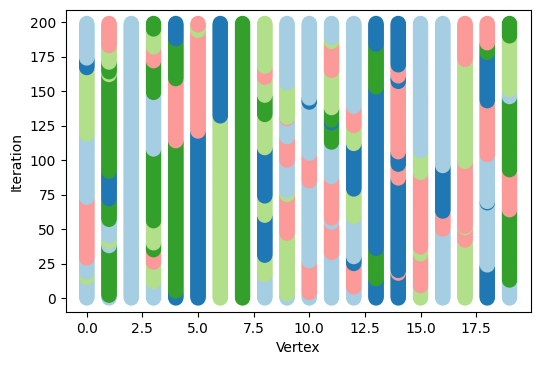

In [9]:
# Plot evolution of the chain
for i in range(200):
    plt.scatter(np.arange(nvertices),i*np.ones(nvertices), c=all_colours[colors_history[i]], s=100)
plt.xlabel("Vertex")
plt.ylabel("Iteration")
plt.show()

# Code for Coupling Chains

In [10]:
# utilities color relabling step
def color_ordering(ncolors, vertex_colors):
    """color_ordering returns the order of occurrence of each color in vertex_colors.
    Unused colors are assigned an order greater than the number of unique colors in 
    vertex_colors.
    """
    complete_list_of_colors = np.array(list(vertex_colors) +  list(range(ncolors)))
    idx_of_first_occurrence = [np.where(complete_list_of_colors==c)[0][0] for c in range(ncolors)]
    return np.argsort(idx_of_first_occurrence)
    
def relabel_colors(ncolors, vertex_colors, new_order):
    old_ordering = color_ordering(ncolors, vertex_colors)
    vertex_colors_new = vertex_colors.copy()
    for c in range(ncolors):
        vertex_colors_new[np.where(vertex_colors==old_ordering[c])] = new_order[c]
    return vertex_colors_new

In [10]:
def max_coupling(v1_probs, v2_probs):
    """max_coupling as described in Jacob's chapter 3 notes.
    """
    ncolors = len(v1_probs)
    
    # compute overlap pmf
    overlap = np.min([v1_probs, v2_probs], axis=0)
    overlap_size = np.sum(overlap)
    overlap_size = np.min([1.0, overlap_size]) # protect from rounding error 
    if np.random.choice(2, p=[1-overlap_size, overlap_size]) == 1:
        newz = np.random.choice(ncolors, p=overlap/overlap_size)
        return newz, newz
    
    # sample from complements independently
    v1_probs -= overlap
    v1_probs /= (1-overlap_size)
    
    v2_probs -= overlap
    v2_probs /= (1-overlap_size)
    
    newz1 = np.random.choice(ncolors, p=v1_probs)
    newz2 = np.random.choice(ncolors, p=v2_probs)
    return newz1, newz2

def opt_coupling(v1_probs, v2_probs, clusts1, clusts2, intersection_sizes):
    """opt_coupling returns a sample from the optimal coupling of v1_probs and v2_probs.
    
    Args:
        v1_probs, v2_probs: marginals for chains 1 and 2
        clusts1, clusts2: color group assignments chains 1 and 2
    """
    assert len(v1_probs) == len(v2_probs)
    ncolors = len(v1_probs)
    pairwise_dists = utils.pairwise_dists(clusts1, clusts2, intersection_sizes, allow_new_clust=False)
    _, (v1_color, v2_color), _ = utils.optimal_coupling(
        v1_probs, v2_probs, pairwise_dists, normalize=True,
        change_size=100)
    return v1_color, v2_color


def double_kernel(g, ncolors, vertex_colors1, vertex_colors2, n, clusts1, clusts2,
                  intersection_sizes, coupling="Maximal"):
    """double_kernel simulates one step for a pair of coupled Markov chains over colorings.
    
    A vertex, n_i, is selected uniformly at random from the set of all vertices and has its 
    color reassigned.  Marginally this assigment is uniformly random over the set of 
    allowable colors.  The joint distribution of their coupling is set by the coupling argument.
    
    
    Args:
        g: graph object
        ncolors: total number of possible colors
        vertex_colors1, vertex_colors2: current color assignments of all vertices in both chains
        n: index of vertex to recolor
        coupling: method of coupling Gibs proposal "Maximal", "Optimal" or "Random"
        
    Returns:
        vertex_colors1, vertex_colors2 : new assignments of vertex colors.
    """
    # remove node n from clusts and intersection sizes
    clusts1[vertex_colors1[n]].remove(n)
    clusts2[vertex_colors2[n]].remove(n)
    intersection_sizes[vertex_colors1[n], vertex_colors2[n]] -= 1
    
    # compute marginal probabilities
    v1_probs = color_probs(g, ncolors, n, vertex_colors1)
    v2_probs = color_probs(g, ncolors, n, vertex_colors2)
    
    # Sample new color assignments from coupling
    if coupling == "Maximal":
        v1_color, v2_color = max_coupling(v1_probs, v2_probs)
    elif coupling == "Common_RNG":
        v1_color, v2_color = utils.naive_coupling(v1_probs, v2_probs)
    elif coupling == "Random":
        # This is an independent coupling
        v1_color = np.random.choice(ncolors, p=v1_probs)
        v2_color = np.random.choice(ncolors, p=v2_probs)
    else:
        # This defines the coupling by solving an optimal transport problem.
        assert coupling == "Optimal"
        v1_color, v2_color = opt_coupling(v1_probs, v2_probs, clusts1, clusts2, intersection_sizes)
        
    # update group assignments and intersection sizes
    clusts1[v1_color].add(n); clusts2[v2_color].add(n)
    intersection_sizes[v1_color, v2_color] += 1
    vertex_colors1[n], vertex_colors2[n] = v1_color, v2_color
    
    return vertex_colors1, vertex_colors2

def gibbs_sweep_couple(g, ncolors, vertex_colors1, vertex_colors2, coupling="Maximal"):
    """gibbs_sweep_couple performs Gibbs updates for every node in the graph, coupling
    each update across the two chains.
    
    We compute intersection sizes once at the start and then update it for better time complexity.
    """
    # Compute clusters and intersection sizes from scratch once
    clusts1 = utils.z_to_clusts(vertex_colors1, total_clusts=ncolors)
    clusts2 = utils.z_to_clusts(vertex_colors2, total_clusts=ncolors)
    intersection_sizes = np.array([[len(c1.intersection(c2)) for c2 in clusts2] for c1 in clusts1])
    
    # sample from conditional for each vertex
    for n in range(g.vcount()):
        vertex_colors1, vertex_colors2 = double_kernel(
            g, ncolors, vertex_colors1.copy(), vertex_colors2.copy(), n,
            clusts1, clusts2, intersection_sizes, coupling=coupling)
    return vertex_colors1, vertex_colors2

In [12]:
def plot_coupling(colors_history_coupled, dists_by_iteration, max_iters_plot=200):
    I = min([max_iters_plot, len(colors_history_coupled)])
    plt.figure(figsize=[3,0.5*I])
    sep_dist = 0.2
    nvertices = len(colors_history_coupled[0][0])
    for i in range(I):
        vertex_colors1, vertex_colors2 = colors_history_coupled[i]
        plt.scatter(np.arange(nvertices),i*np.ones(nvertices), c=all_colours[vertex_colors1], s=100)
        plt.scatter(np.arange(nvertices),i*np.ones(nvertices) + sep_dist, c=all_colours[vertex_colors2], s=100)
    plt.xlabel("Vertex")
    plt.ylabel("Iteration")
    plt.show()

    plt.plot(dists_by_iteration)
    plt.xlabel("Iteration")
    plt.ylabel("Distance Between Adjacency Matrices")
    plt.show()

# Using maximal coupling

coupled after 19 iterations!
plotting


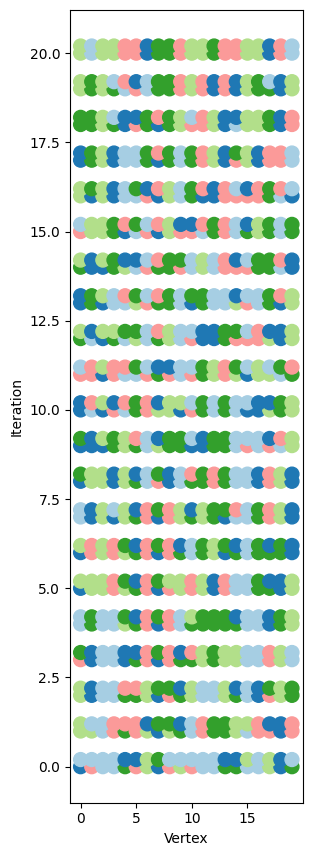

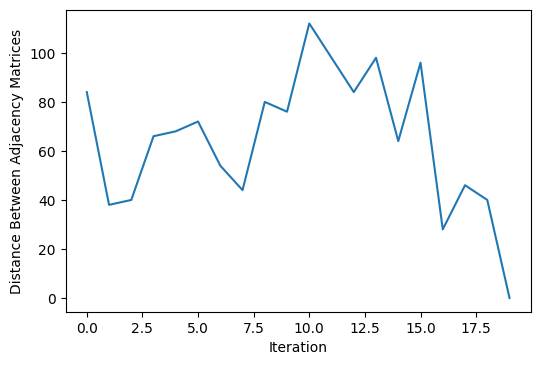

In [12]:
vertex_colors1 = colors_history[-1].copy() # (i.e. lagged)
vertex_colors2 = rinit(g)
colors_history_coupled = [(vertex_colors1, vertex_colors2)]

nmcmc = int(5e3)
dists_by_iteration = []
for imcmc in range(nmcmc):
    #vertex_colors1, vertex_colors2 = double_kernel(
    #    g, ncolors, vertex_colors1.copy(), vertex_colors2.copy(), coupling="Maximal")
    vertex_colors1, vertex_colors2 = gibbs_sweep_couple(
        g, ncolors, vertex_colors1, vertex_colors2, coupling="Maximal")
    dist = utils.dist_from_labeling(vertex_colors1, vertex_colors2)
    dists_by_iteration.append(dist)
    colors_history_coupled.append([vertex_colors1, vertex_colors2])
    if dist==0:
        print("coupled after %d iterations!"%imcmc)
        break
        
print("plotting")
plot_coupling(colors_history_coupled, dists_by_iteration,max_iters_plot=200)

# Using Optimal Transport Coupling

coupled after 16 iterations!


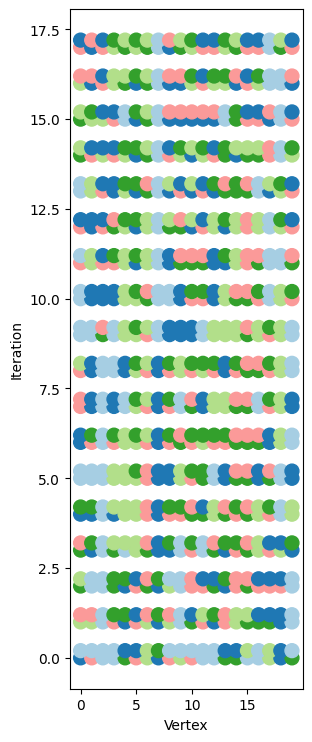

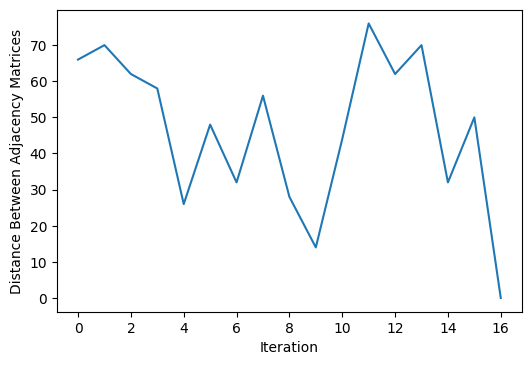

In [13]:
vertex_colors1 = colors_history[-1].copy() # (i.e. lagged)
vertex_colors2_init = rinit(g)
colors_history_coupled = [(vertex_colors1, vertex_colors2_init)]

nmcmc = int(5e3)
dists_by_iteration = []
for imcmc in range(nmcmc):
    vertex_colors1, vertex_colors2 = colors_history_coupled[-1]
    #vertex_colors1, vertex_colors2 = double_kernel(
    #    g, ncolors, vertex_colors1.copy(), vertex_colors2.copy(), coupling="Optimal")
    vertex_colors1, vertex_colors2 = gibbs_sweep_couple(
        g, ncolors, vertex_colors1, vertex_colors2, coupling="Optimal")
    dist = utils.dist_from_labeling(vertex_colors1, vertex_colors2)
    dists_by_iteration.append(dist)
    colors_history_coupled.append([vertex_colors1, vertex_colors2])
    if dist==0:
        print("coupled after %d iterations!"%imcmc)
        break
        
plot_coupling(colors_history_coupled, dists_by_iteration)

In [14]:
def prop_in_k_colors(vertex_colors, ncolors):
    clusts = utils.z_to_clusts(vertex_colors, total_clusts=ncolors)
    clust_sizes = sorted([len(clust) for clust in clusts], reverse=True)
    return np.cumsum(clust_sizes)/len(vertex_colors)

def pi0(g, ncolors, pi0_its=0):
    X0 = rinit(g)
    for i in range(pi0_its): X0 = gibbs_sweep_single(g, ncolors, X0.copy())
    return X0

def unbiased_est_coloring(k, h, m, g, ncolors, pi0_its=0, coupling="Maximal"):#
    """unbiased_est produces an unbiased estimate of a functional using the approach of Jacob 2020
    
    initializes from r_init
    
    Args:
        k: # burn-in iterations
        h: function of interest (of labelings z)
        m: minimum iterations
        g: graph
        ncolors: number of unique colors
        pi0_its: number of iterations to run before coupling
        coupling: either maximal or optimal
    """
    pi0_g = lambda : pi0(g, ncolors, pi0_its)
    
    # Define marginal and coupled transitions
    single_transition = lambda v_cols: gibbs_sweep_single(g, ncolors, v_cols.copy())
    double_transition = lambda v_cols1, v_cols2: gibbs_sweep_couple(
        g, ncolors, v_cols1, v_cols2, coupling=coupling)
    
    # Run coupled chains
    X, Y, tau = unbiased_estimation.run_two_chains(m, pi0_g, single_transition, double_transition, 
                                                   time_budget=100)
    
    # Compute unbiased estimate
    H_km = unbiased_estimation.unbiased_est(k, h, m, X, Y, tau)

    return H_km

In [15]:
# Compute & Average unbiased estimates
k, h, m, pi0_its = 50, lambda v_cols: prop_in_k_colors(v_cols, ncolors=ncolors), 100, 2
print("pi0_its", pi0_its)
M = 25
ests_ub = [unbiased_est_coloring(k, h, m, g, ncolors, pi0_its, coupling='Optimal') for _ in range(M)]
print("est += SE : ", np.mean(ests_ub,axis=0), "+-", stats.sem(ests_ub,axis=0))
print("1000*var[est]: ", 1000*np.var(ests_ub,axis=0))

pi0_its 2
est += SE :  [0.2882 0.5224 0.7184 0.8803 1.    ] +- [0.0013 0.0014 0.001  0.0008 0.    ]
1000*var[est]:  [0.0422 0.0484 0.0225 0.0141 0.    ]


In [16]:
# estimate with one lone chain
def MCMC_est(I=50):
    X = [rinit(g)]
    for _ in range(I):
        X.append(gibbs_sweep_single(g, ncolors, X[-1].copy()))
    ests = [h(x) for x in X]
    mean = np.mean(ests[int(I/2):],axis=0)
    print("MCMC est: ", mean)
    
# run two MCMC chains
MCMC_est()
MCMC_est()

MCMC est:  [0.2981 0.5288 0.7231 0.8808 1.    ]
MCMC est:  [0.2885 0.5096 0.6981 0.8692 1.    ]


In [17]:
def run_rep(n=20, p=0.15, max_iter=1000):
    g = igraph.Graph.Erdos_Renyi(n, p)

        # initialization for chain 1
    colors_history = [rinit(g)]
    vertex_colors_init = rinit(g)

    ## all possible colours
    ncolors = len(set(colors_history[-1]))+1 # good
    print("n colors: ", ncolors)
    
    nmcmc = 1000
    for imcmc in range(nmcmc):
        vertex_colors_new = single_kernel(g, ncolors, colors_history[-1].copy())
        colors_history.append(vertex_colors_new)
    vertex_colors1_init = colors_history[-1]
    vertex_colors2_init = rinit(g)
    
    nmcmc = int(max_iter)
    # Optimal Coupling
    dists_by_iteration = []
    colors_history_coupled = [(vertex_colors1_init.copy(), vertex_colors2_init.copy())]
    st = clock()
    for imcmc in range(nmcmc):
        vertex_colors1, vertex_colors2 = colors_history_coupled[-1]
        vertex_colors1, vertex_colors2 = gibbs_sweep_couple(
            g, ncolors, vertex_colors1.copy(), vertex_colors2.copy(), coupling="Optimal")
        dist = utils.dist_from_labeling(vertex_colors1, vertex_colors2)
        dists_by_iteration.append(dist)
        colors_history_coupled.append([vertex_colors1, vertex_colors2])
        if dist==0: break
    end = clock()
    trace_optimal = dists_by_iteration
    time_optimal = end-st
        
    # Maximal coupling 
    dists_by_iteration = []
    colors_history_coupled = [(vertex_colors1_init.copy(), vertex_colors2_init.copy())]
    st = clock()
    for imcmc in range(nmcmc):
        vertex_colors1, vertex_colors2 = colors_history_coupled[-1]
        vertex_colors1, vertex_colors2 = gibbs_sweep_couple(
            g, ncolors, vertex_colors1.copy(), vertex_colors2.copy(), coupling="Maximal")
        dist = utils.dist_from_labeling(vertex_colors1, vertex_colors2)
        dists_by_iteration.append(dist)
        colors_history_coupled.append([vertex_colors1, vertex_colors2])
        if dist==0: break
    end = clock()
    trace_maximal = dists_by_iteration
    time_maximal = end-st
    
    # Common RNG
    dists_by_iteration = []
    colors_history_coupled = [(vertex_colors1_init.copy(), vertex_colors2_init.copy())]
    st = clock()
    for imcmc in range(nmcmc):
        vertex_colors1, vertex_colors2 = colors_history_coupled[-1]
        vertex_colors1, vertex_colors2 = gibbs_sweep_couple(
            g, ncolors, vertex_colors1.copy(), vertex_colors2.copy(), coupling="Common_RNG")
        dist = utils.dist_from_labeling(vertex_colors1, vertex_colors2)
        dists_by_iteration.append(dist)
        colors_history_coupled.append([vertex_colors1, vertex_colors2])
        if dist==0: break
    end = clock()
    trace_rng = dists_by_iteration
    time_rng = end-st

    return trace_maximal, trace_optimal, trace_rng, time_maximal, time_optimal, time_rng

In [21]:
n_reps = 250
n, p = 25, 0.2 # even better (don't delete)
maxIters = int(1e5)

traces_by_coupling = {"Optimal":[], "Maximal":[], "Common_RNG":[]}
times_by_coupling = {"Optimal":[], "Maximal":[], "Common_RNG":[]}

run_in_parallel = True
if run_in_parallel:
    pool_size = 18
    def simulate(_):
        result = run_rep(n, p, max_iter=maxIters)
        print("complete")
        return result
    with Pool(pool_size) as p:
        results = p.map(simulate, range(n_reps))
    
    for (trace_maximal, trace_optimal, trace_rng, time_maximal, time_optimal, time_rng) in results:
        traces_by_coupling["Optimal"].append(trace_optimal)
        traces_by_coupling["Maximal"].append(trace_maximal)
        traces_by_coupling["Common_RNG"].append(trace_rng)
        times_by_coupling["Optimal"].append(time_optimal)
        times_by_coupling["Maximal"].append(time_maximal)
        times_by_coupling["Common_RNG"].append(time_rng)
else:
    for rep in range(n_reps):
        if (10*rep)%n_reps==0: print("Rep %04d/%04d"%(rep, n_reps))

        trace_maximal, trace_optimal, trace_rng, time_maximal, time_optimal, time_rng = run_rep(
            n, p, max_iter=maxIters)
        traces_by_coupling["Optimal"].append(trace_optimal)
        traces_by_coupling["Maximal"].append(trace_maximal)
        traces_by_coupling["Common_RNG"].append(trace_rng)
        times_by_coupling["Optimal"].append(time_optimal)
        times_by_coupling["Maximal"].append(time_maximal)
        times_by_coupling["Common_RNG"].append(time_rng)

n colors: n colors: n colors: n colors: n colors: n colors: n colors: n colors: n colors:  n colors:  n colors: n colors:  n colors:  n colors: n colors:   n colors: n colors:  n colors: 6   6  66  6   5
65 6
666

76
5
6

6
6








complete
n colors:  6
complete
n colors:  5
complete
n colors:  6
complete
n colors:  5
complete
n colors:  5
complete
n colors:  5
complete
n colors:  5
complete
n colors:  6
complete
n colors:  6
complete
n colors:  5
complete
n colors:  6
complete
n colors:  6
complete
n colors:  6
complete
n colors:  6
complete
n colors:  6
complete
n colors:  6
complete
n colors:  6
complete
n colors:  6
complete
n colors:  5
complete
n colors:  6
complete
n colors:  5
complete
n colors:  5
complete
n colors:  6
complete
n colors:  5
complete
n colors:  5
complete
n colors:  6
complete
n colors:  5
complete
n colors:  6
complete
n colors:  5
complete
n colors:  7
complete
n colors:  5
complete
n colors:  6
complete
n colors:  5
complete
n colors:  6
complete
n colors:

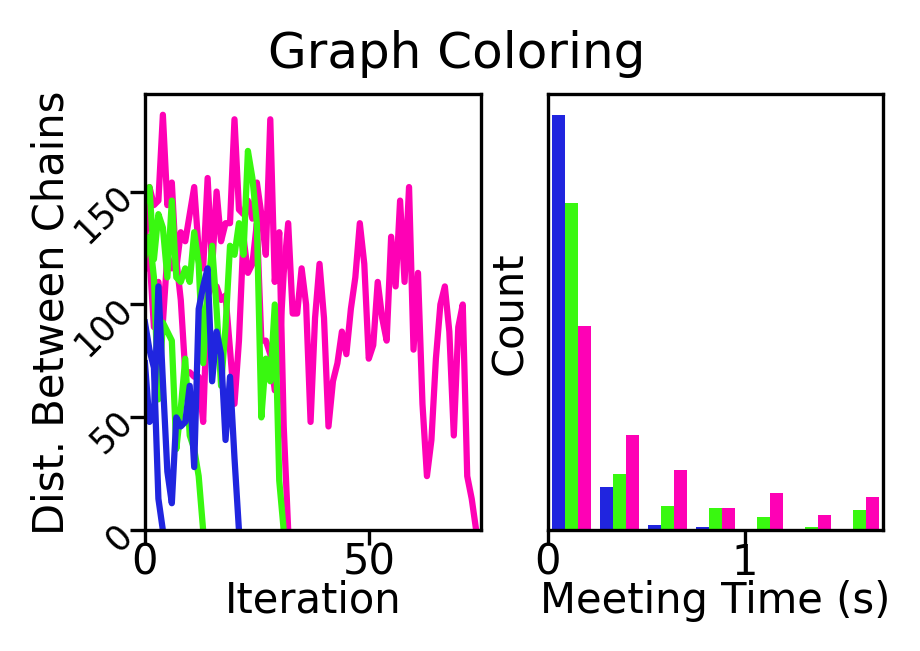

In [33]:
import copy
fn_base = "./toy_data_results/N=25_p=0.2"
traces_by_coupling_N25_p02 = copy.deepcopy(traces_by_coupling)
traces_fn = fn_base + "_traces.npy"
np.save(traces_fn, traces_by_coupling_N25_p02)

times_by_coupling_N25_p02 = copy.deepcopy(times_by_coupling)
times_fn = fn_base + "_meeting_times.npy"
np.save(times_fn, times_by_coupling_N25_p02)

title = "Graph Coloring"
np.random.seed(47)
utils.meeting_times_plots(
    traces_by_coupling, times_by_coupling, 
    couplings_plot=['Optimal', 'Maximal', 'Common_RNG'],
    couplings_colors=['#2025df', '#39f810','#fe01b5'], title=title, alpha=1.0, nbins=8, max_time=1.7,
    linewidth=1.5, iter_interval=None, n_traces_plot=2, max_iter=None
    )

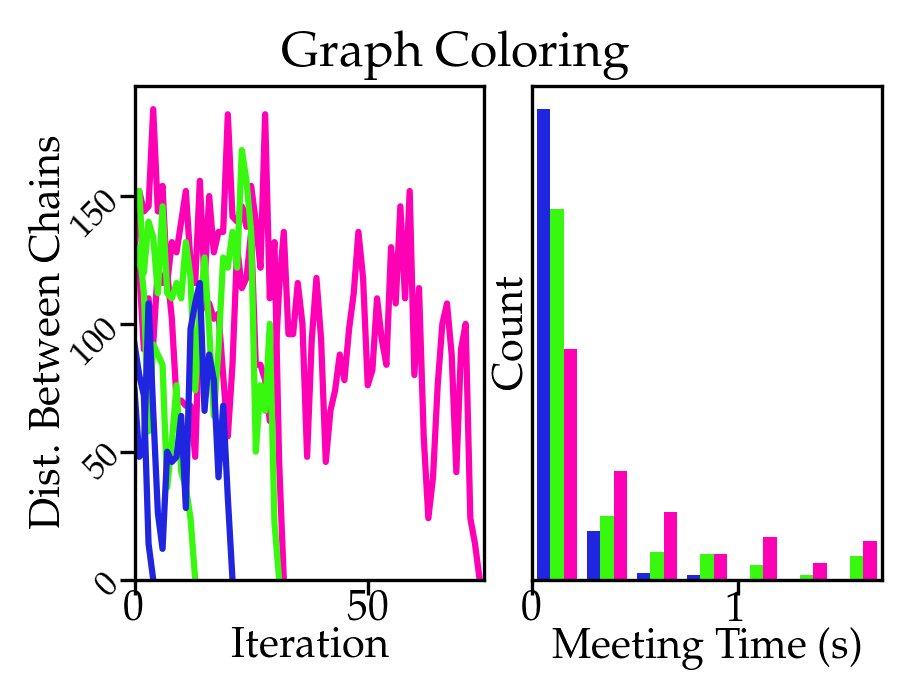

In [44]:
#fn_base = "../toy_data_results/N=25_p=0.2"
#traces_fn = fn_base + "_traces.npy"
#traces_by_coupling = np.load(traces_fn, allow_pickle=True).item()
#
#times_fn = fn_base + "_meeting_times.npy"
#times_by_coupling = np.load(times_fn, allow_pickle=True).item()

imp.reload(utils)
title = "Graph Coloring"
np.random.seed(47)
utils.meeting_times_plots(
    traces_by_coupling, times_by_coupling, 
    couplings_plot=['Optimal', 'Maximal', 'Common_RNG'],
    couplings_colors=['#2025df', '#39f810','#fe01b5'], title=title, alpha=1.0, nbins=8, max_time=1.7,
    linewidth=1.5, iter_interval=None, n_traces_plot=2, max_iter=None
    )

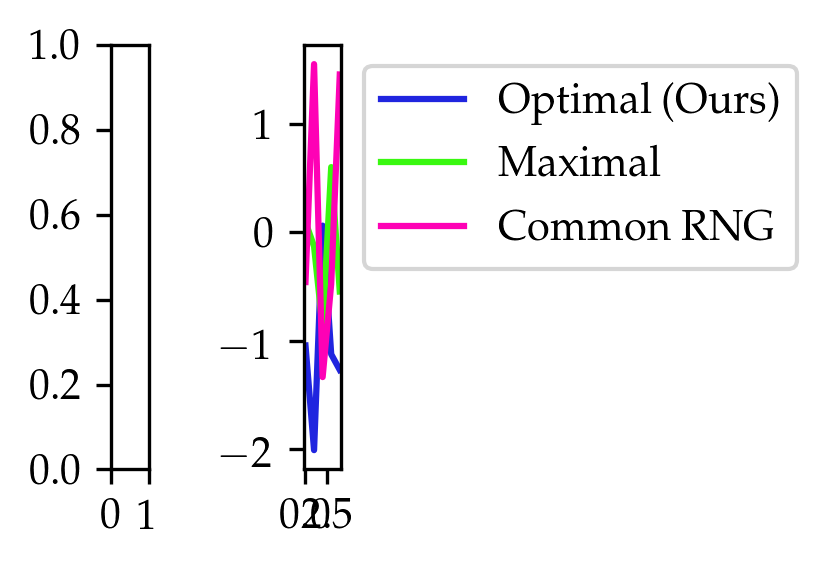

In [45]:
# For generating legend only...
couplings_plot=['Optimal (Ours)', 'Maximal', 'Common RNG']
couplings_colors=['g','b','k']
couplings_colors=['#2025df', '#39f810','#fe01b5']
f, axarr = plt.subplots(ncols=2, figsize=[2.9, 2.0], dpi=300)
for coupling, color in list(zip(couplings_plot, couplings_colors)):
    axarr[1].plot(np.random.normal(size=5), label=coupling, color=color)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', )
plt.tight_layout()
plt.show()


# Random independent coupling (Sanity Check)

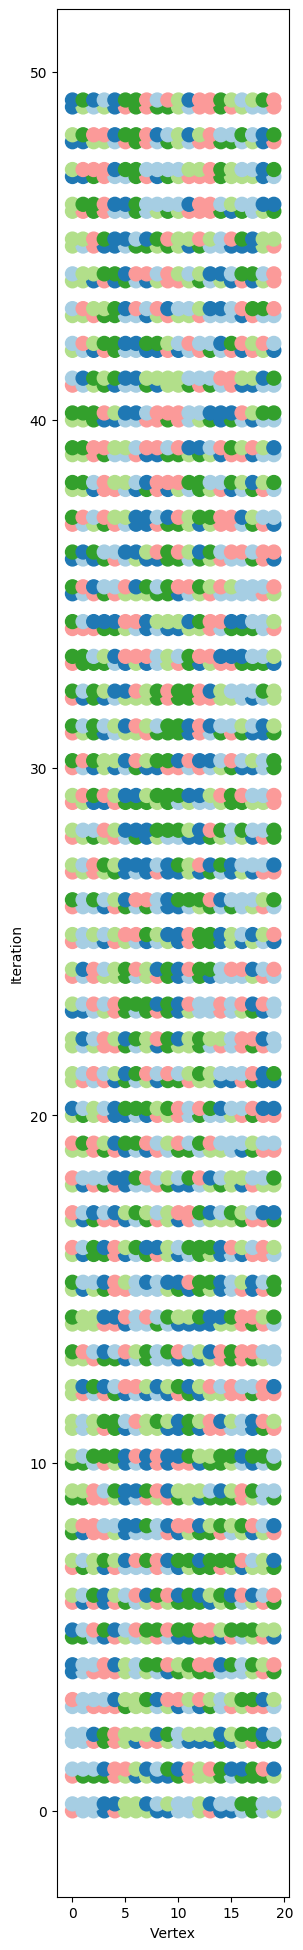

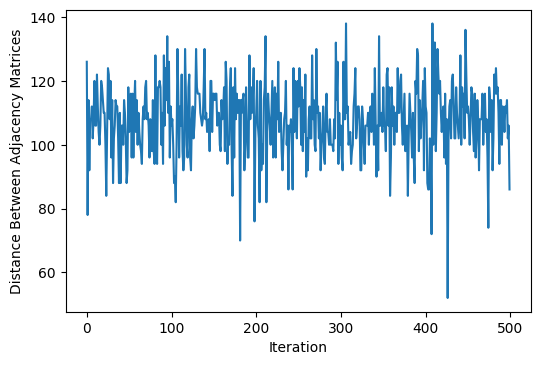

In [17]:
vertex_colors1 = colors_history[-1].copy() # (i.e. lagged)
vertex_colors2 = rinit(g)
colors_history_coupled = [(vertex_colors1.copy(), vertex_colors2.copy())]

nmcmc = int(5e2)
dists_by_iteration = []
for imcmc in range(nmcmc):
    vertex_colors1, vertex_colors2 = gibbs_sweep_couple(
        g, ncolors, vertex_colors1.copy(), vertex_colors2.copy(), coupling="Random")
    dist = utils.dist_from_labeling(vertex_colors1, vertex_colors2)
    dists_by_iteration.append(dist)
    colors_history_coupled.append([vertex_colors1.copy(), vertex_colors2.copy()])
    if dist==0:
        print("coupled after %d iterations!"%imcmc)
        break
        
plot_coupling(colors_history_coupled, dists_by_iteration, max_iters_plot=50)

In [34]:
# networkx plotting
# for plotting 
import networkx as nx

# delete nodes without edges
to_delete_ids = [v.index for v in g.vs if v.degree() == 0]
to_keep_ids = [v.index for v in g.vs if v.degree() != 0]

g.delete_vertices(to_delete_ids)

## number of vertices in the graph

nvertices = g.vcount()

vertex_colors_init = rinit(g)
print(vertex_colors_init)

## all possible colours
ncolors = len(set(vertex_colors_init))+2
all_colours = np.array(sns.color_palette("Paired", n_colors=ncolors))

[0 0 0 1 1 2 2 1 0 2 0 0 2 1 0 3 3 0 0]


0 [ 1  2 10 11 16 18]
1 [ 3  8  9 14 15]
2 [ 5  6  7 12]
3 [17]
4 [ 0  4 13]


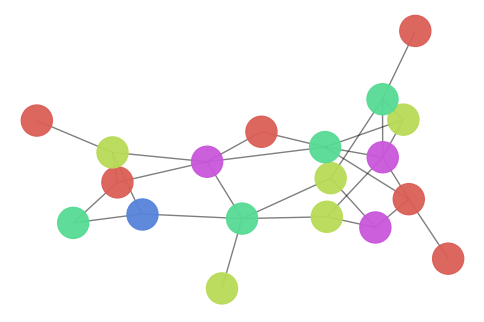

In [40]:
edges = g.get_edgelist()
G = nx.Graph(edges)
pos=nx.spring_layout(G) # positions for all nodes
vcolors = colors_history[-1]
vcolors = vcolors.copy()[to_keep_ids]
n_colors_init = len(np.unique(vcolors))
all_colours_plot = np.array(sns.color_palette("hls", n_colors=n_colors_init))
for i in range(n_colors_init):
    nodes = np.where(vcolors==i)[0]
    print(i, nodes)
    # filter out nodes without neighbors
    nx.draw_networkx_nodes(G,pos,
                           nodelist=nodes,
                           node_color=[all_colours_plot[i]]*len(nodes),
                           node_size=500,
                       alpha=0.95)
nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)

plt.axis('off')
#plt.savefig("labels_and_colors.png") # save as png
plt.show() # display